In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *

In [135]:
# parameters
J = 1
kB = 1
Tc = 2/np.log(1+np.sqrt(2))
Kc = np.log(1+np.sqrt(2))/2

## Exact solution for 2x2 lattice

In [136]:
#  exact solution for 2 by 2 lattice
def exact(beta):
    Z = 2*np.exp(8*beta)+12+2*np.exp(-8*beta)
    F = -np.log(Z)/beta
    E = -(2*8*np.exp(8*beta)+2*(-8)*np.exp(-8*beta))/Z
    E_sqr = (2*64*np.exp(8*beta) +2*64*np.exp(-8*beta))/Z
    C = (E_sqr-E*E)*(beta*beta)
    M_abs = (2*4*np.exp(8*beta)+8*2)/Z
    M_sqr = (2*16*np.exp(8*beta)+8*4)/Z
    chi_p = (M_sqr-M_abs*M_abs)*beta
    
    return Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p


## Bare tensors

In [137]:
#==================================================================#
##
##          3             3       
##     2--(TO)--0     2--(T1)--0
##          1              1  
##
##          3             3 
##     2--(T3)--0     2--(T2)--0
##          1             1 
#==================================================================#

## Contraction on a 2x2 lattice

Construct bare tensors $T$ and $T_z$ for the 2D Ising model.

Perform exact contract on a 2x2 lattice to obtain
* Partition function $Z$.
* Energy per bond. (via <S(0,0) S(0,1)>).
* Correlation at maximal distance <S(0,0> S(1,1)>.

Compare to the exact results on a 2x2 lattice.

In [138]:
#照paper上的方法 把transition tensor造出來(一個rank 4 tensor)
def W(T):
    return np.array([[np.cosh(1/T)**(1/2),np.sinh(1/T)**(1/2)]
                    ,[np.cosh(1/T)**(1/2),-(np.sinh(1/T))**(1/2)]])
def tran_matrix(T):
    a=np.zeros([2,2,2,2])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for n in range(2):
                        a[i,j,k,l]+=W(T)[n,i]*W(T)[n,j]*W(T)[n,k]*W(T)[n,l]
    return a

tran_matrix(1)

array([[[[4.76219569, 0.        ],
         [0.        , 3.62686041]],

        [[0.        , 3.62686041],
         [3.62686041, 0.        ]]],


       [[[0.        , 3.62686041],
         [3.62686041, 0.        ]],

        [[3.62686041, 0.        ],
         [0.        , 2.76219569]]]])

In [139]:
#define 兩個 rank 4 tensor  a 和 b component 都是符號
def tensor():
    a=np.full([2,2,2,2],None)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for n in range(2):
                        x=Symbol("a"+str(i)+str(j)+str(k)+str(l))
                        a[i,j,k,l]=x
    return a
def tensor2():
    a=np.full([2,2,2,2],None)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for n in range(2):
                        x=Symbol("b"+str(i)+str(j)+str(k)+str(l))
                        a[i,j,k,l]=x
    return a

a=tensor()
b=tensor2()
# 用a的第一個index和 b的第三個index 做contraction (所以axis就是設[0,2])
A=np.tensordot(a,b,[0,2])


A[0,0,0,0,0,0] 




a0000*b0000 + a1000*b0010

In [140]:
A[0,0,0,0,1,0]
#可以看出 新的tensor A 的第四個index 對應到 b的第2個index

a0000*b0100 + a1000*b0110

<img src="tensor.png" style="width:400px;height:300px"/>        

In [141]:
#計算partition function
def par(T):
    p=0
    a=tran_matrix(T)
    #上面兩個 下面兩個分別先做contraction 得到兩個rank 6 tensor
    b=np.tensordot(a,a,[0,2])
    c=np.tensordot(a,a,[0,2])
    
    #上下兩個做contraction
    d=np.tensordot(b,c,[(0,4),(2,5)])
    
    #做trace得出partition function
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    p+=d[i,j,k,i,l,k,j,l]
                    
        
  
    return p 
par(1)

5971.989236639011

In [142]:
#compute impurity tensor Tz
def imp_tensor(T):
    a=np.zeros([2,2,2,2])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    if i==j==k==l==0:
                        a[i,j,k,l]+=1 
                    if i==j==k==l==1:
                        a[i,j,k,l]+=-1 
    a1=np.tensordot(a,W(T),[0,0])
    a2=np.tensordot(a1,W(T),[0,0])
    a3=np.tensordot(a2,W(T),[0,0])
    a4=np.tensordot(a3,W(T),[0,0])
    return a4
imp_tensor(1)

array([[[[0.        , 4.1559378 ],
         [4.1559378 , 0.        ]],

        [[4.1559378 , 0.        ],
         [0.        , 3.16513794]]],


       [[[4.1559378 , 0.        ],
         [0.        , 3.16513794]],

        [[0.        , 3.16513794],
         [3.16513794, 0.        ]]]])

In [143]:
#check <Sij>=0
def test(T):
    u=0
    S=tran_matrix(T)
    Tz=imp_tensor(T)
    S1=np.tensordot(S,S,[0,2])
    TzS=np.tensordot(Tz,S,[0,2])
    U=np.tensordot(TzS,S1,[(0,4),(2,5)])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    u+=U[i,j,k,i,l,k,j,l]
    return u
print(test(27),test(1),test(0.8783))

0.0 0.0 0.0


In [147]:
def avg_bond_U(T):
    u=0
    S=tran_matrix(T)
    Tz=imp_tensor(T)
    S1=np.tensordot(S,S,[0,2])
    Tzz=np.tensordot(Tz,Tz,[0,2])
    U=np.tensordot(Tzz,S1,[(0,4),(2,5)])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    u+=U[i,j,k,i,l,k,j,l]
    return -u/par(T) 
avg_bond_U(2)
"     I     I       "
"  ---Tz----Tz---   "
"     I     I       "
"  ---S-----S----   "
"     I     I        "

-0.9241451378620367

In [149]:
#compute correlation
def cor(T):
    u=0
    S=tran_matrix(T)
    Tz=imp_tensor(T)
    TS=np.tensordot(Tz,S,[0,2])
    ST=np.tensordot(S,Tz,[0,2])
    U=np.tensordot(TS,ST,[(0,4),(2,5)])
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    u+=U[i,j,k,i,l,k,j,l]
    return u/par(T) 
cor(15)
"     I     I        "
"  ---Tz----S---   "
"     I     I       "
"  ---S-----Tz---   "
"     I     I"

0.08554703518316994

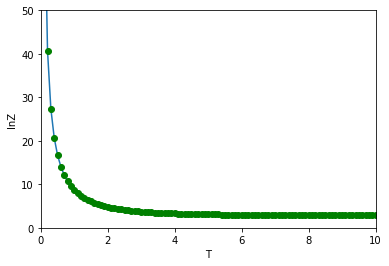

In [150]:
#compare direct calculation of partition (a2)  with tensor calculation(a1)
a1=[]
a2=[]
x=[]
for i in range(1,1000):
    a1.append(np.log(par(i/10)))
    a2.append(np.log(exact(10/i)[0]))
    x.append(i/10)
plt.xlim(0,10)
plt.ylim(0,50)
plt.ylabel('lnZ')
plt.xlabel('T')
plt.plot(x,a1,x,a2,'go')

    

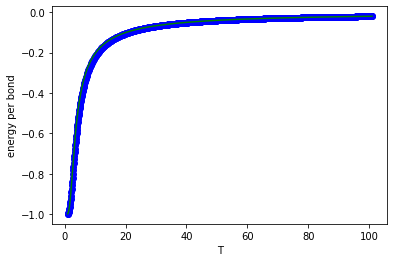

In [151]:
##compare direct calculation of energy (u2)  with tensor calculation(u)
u=[]
u2=[]
x=[]
for i in range(1000):
    x.append(i/10+1)
    u2.append(exact(1/(i/10+1))[2]/8)
    u.append(avg_bond_U(i/10+1))
plt.xlabel("T")
plt.ylabel("energy per bond")
plt.plot(x,u,"bo",x,u2,"g")

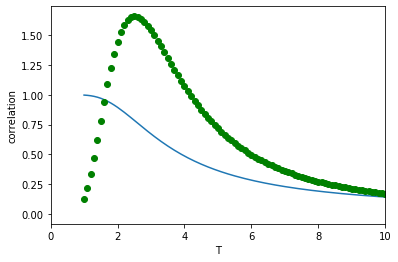

In [152]:
#compare direct calculation of correlation (c2)  with tensor calculation(c)
c=[]
c2=[]
x=[]
for i in range(1000):
    x.append(i/10+1)
    c2.append(exact(1/(i/10+1))[4])
    c.append(cor(i/10+1))
plt.xlabel("T")
plt.ylabel("correlation")
plt.xlim(0,10)
plt.plot(x,c,x,c2,"go")
#不知為何不吻合